# Read Papers CSV

In [2]:
import pandas as pd

df = pd.read_csv("irpapers-docs.csv")

In [3]:
test = df.iloc[0]

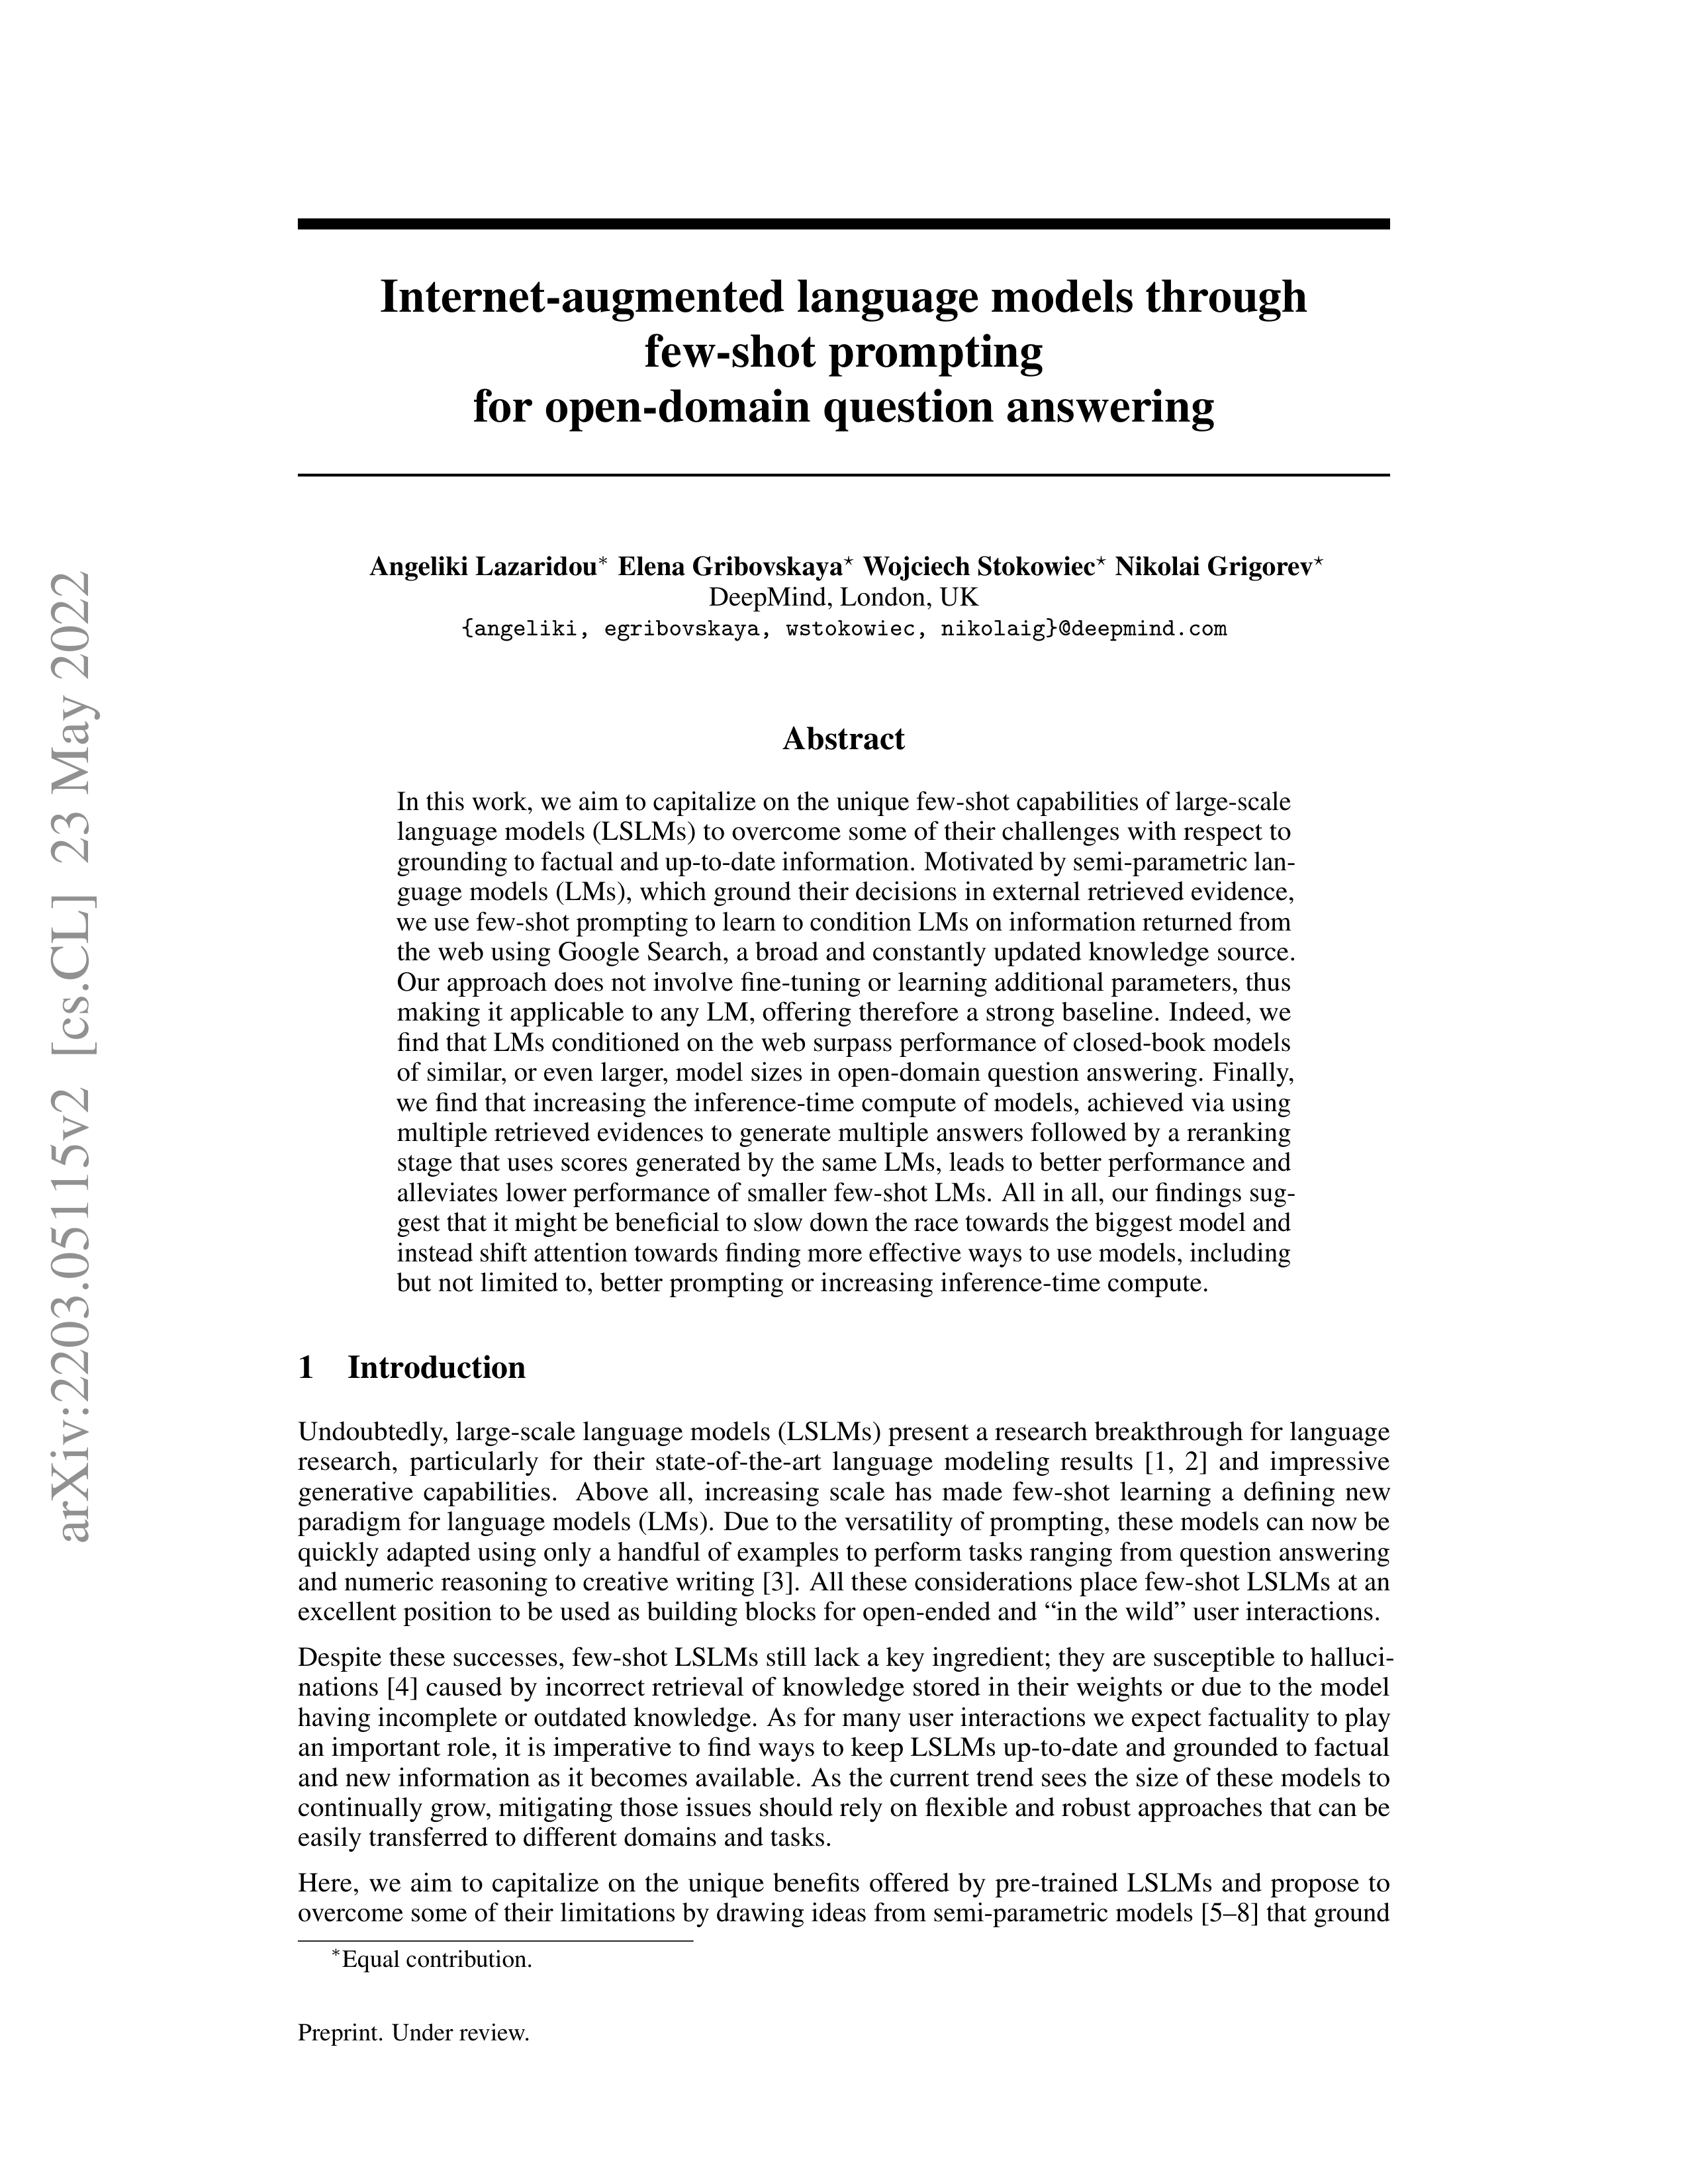

In [4]:
from IPython.display import Image, display
from base64 import b64decode
display(Image(b64decode(test["base64_str"])))

# Demonstrate GPT-4.1 PDF to Text Ability

In [5]:
from openai import OpenAI

client = OpenAI()

base64_str = test["base64_str"]

transcribe_pdf_image_to_text_prompt = """
Can you please transcribe the content from this PDF page into a text format?
If you come across tables, please transcribe them into markdown formatted text.
If you come across images, please just omit them and use their provided caption in the text format.
Please do not begin your response with "Here is the transcription of the image:" or anything similar, just start with the text transcription.
"""

def request_openai_transcription(transcription_prompt: str, base64_str: str):
    response = client.responses.create(
        model="gpt-4.1",
        input=[
            {
                "role": "user",
                "content": [
                    { "type": "input_text", "text": transcribe_pdf_image_to_text_prompt },
                    {
                        "type": "input_image",
                        "image_url": f"data:image/png;base64,{base64_str}"
                    }
                ]
            }
        ]
    )
    return response

response = request_openai_transcription(transcribe_pdf_image_to_text_prompt, base64_str)

In [6]:
print(f"Input Tokens: {response.usage.input_tokens}")
print(f"Output Tokens: {response.usage.output_tokens}")

Input Tokens: 851
Output Tokens: 634


In [7]:
from IPython.display import display, Markdown

def pretty_print_transcription(text: str, max_lines: int = 30):
    """Pretty print a long text with Markdown and optionally fold long outputs."""
    lines = text.splitlines()
    # Collapse output if too long
    if len(lines) > max_lines:
        summary = "\n".join(lines[:max_lines])
        summary += f"\n\n<details><summary>Show more...</summary>\n\n" + "\n".join(lines[max_lines:]) + "\n</details>"
        display(Markdown(summary))
    else:
        display(Markdown(text))

transcribed_text = response.output[0].content[0].text
pretty_print_transcription(transcribed_text)

Internet-augmented language models through few-shot prompting  
for open-domain question answering

Angeliki Lazaridou* Elena Gribovskaya* Wojciech Stokowiec* Nikolai Grigorev*
DeepMind, London, UK  
{angeliki, egribovskaya, wstokowiec, nikolaig}@deepmind.com

*Equal contribution.

Abstract

In this work, we aim to capitalize on the unique few-shot capabilities of large-scale language models (LSLMs) to overcome some of their challenges with respect to grounding to factual and up-to-date information. Motivated by semi-parametric language models (LMs), which ground their decisions in external retrieved evidence, we use few-shot prompting to learn to condition LMs on information returned from the web using Google Search, a broad and constantly updated knowledge source. Our approach does not involve fine-tuning or learning additional parameters, thus making it applicable to any LM, offering therefore a strong baseline. Indeed, we find that LMs conditioned on the web surpass performance of closed-book models of similar, or even larger, model sizes in open-domain question answering. Finally, we find that increasing the inference-time compute of models, achieved via using multiple retrieved evidences to generate multiple answers followed by a reranking stage that uses scores generated by the same LMs, leads to better performance and alleviates lower performance of smaller few-shot LMs. All in all, our findings suggest that it might be beneficial to slow down the race towards the biggest model and instead shift attention towards finding more effective ways to use models, including but not limited to, better prompting or increasing inference-time compute.

1 Introduction

Undoubtedly, large-scale language models (LSLMs) present a research breakthrough for language research, particularly for their state-of-the-art language modeling results [1, 2] and impressive generative capabilities. Above all, increasing scale has made few-shot learning a defining new paradigm for language models (LMs). Due to the versatility of prompting, these models can now be quickly adapted using only a handful of examples to perform tasks ranging from question answering and numeric reasoning to creative writing [3]. All these considerations place few-shot LSLMs at an excellent position to be used as building blocks for open-ended and “in the wild” user interactions.

Despite these successes, few-shot LSLMs still lack a key ingredient; they are susceptible to hallucinations [4] caused by incorrect retrieval of knowledge stored in their weights or due to the model having incomplete or outdated knowledge. As for many user interactions we expect factuality to play an important role, it is imperative to find ways to keep LSLMs up-to-date and grounded to factual and new information as it becomes available. As the current trend sees the size of these models to continually grow, mitigating those issues should rely on flexible and robust approaches that can be easily transferred to different domains and tasks.

Here, we aim to capitalize on the unique benefits offered by pre-trained LSLMs and propose to overcome some of their limitations by drawing ideas from semi-parametric models [5-8] that ground...

# Async Transcription

In [8]:
df.iloc[0].keys()

Index(['dataset_id', 'pdf_id', 'pdf_name', 'pdf_title', 'page_number',
       'base64_str', 'base64_bytes'],
      dtype='object')

In [9]:
from openai import AsyncOpenAI
import asyncio
from typing import Any

# prepare data
tests = []
for i in range(len(df)):
    tests.append((df.iloc[i]["base64_str"], df.iloc[i]["dataset_id"]))
    if i == 4: # test with 5 pages
        break

# get OpenAI client
openai_async_client = AsyncOpenAI()

# define transcription prompt
transcribe_pdf_image_to_text_prompt = """
Can you please transcribe the content from this PDF page into a text format?
If you come across tables, please transcribe them into markdown formatted text.
If you come across images, please just omit them and use their provided caption in the text format.
Please do not begin your response with "Here is the transcription of the image:" or anything similar, just start with the text transcription.
"""

async def transcribe_page(
    openai_async_client: Any, 
    transcription_prompt: str,
    dataset_id: str, 
    base64_str: str
):
    response = await openai_async_client.responses.create(
        model="gpt-4.1",
        input=[
            {
                "role": "user",
                "content": [
                    { "type": "input_text", "text": transcription_prompt },
                    {
                        "type": "input_image",
                        "image_url": f"data:image/png;base64,{base64_str}"
                    }
                ]
            }
        ]
    )
    return {
        "dataset_id": dataset_id,
        "transcription": response.output[0].content[0].text,
        "transcription_input_tokens": response.usage.input_tokens,
        "transcription_output_tokens": response.usage.output_tokens
    }

# List your jobs here (for demonstration, using test1 and test2)
tasks = []
for base64_str, pdf_id in tests:
    task = transcribe_page(openai_async_client, transcribe_pdf_image_to_text_prompt, pdf_id, base64_str)
    tasks.append(task)

responses = await asyncio.gather(*tasks)

# Transcribe `ir-papers`

In [10]:
responses[0]

{'dataset_id': '98_1',
 'transcription': 'Internet-augmented language models through few-shot prompting for open-domain question answering\n\nAngeliki Lazaridou* Elena Gribovskaya* Wojciech Stokowiec* Nikolai Grigorev*\nDeepMind, London, UK\n{angeliki, egribovskaya, wstokowiec, nikolaig}@deepmind.com\n\nAbstract\nIn this work, we aim to capitalize on the unique few-shot capabilities of large-scale language models (LSLMs) to overcome some of their challenges with respect to grounding to factual and up-to-date information. Motivated by semi-parametric language models (LMs), which ground their decisions in external retrieved evidence, we use few-shot prompting to learn to condition LMs on information returned from the web using Google Search, a broad and constantly updated knowledge source. Our approach does not involve fine-tuning or learning additional parameters, thus making it applicable to any LM, offering therefore a strong baseline. Indeed, we find that LMs conditioned on the web s

In [11]:
len(df)

3230

In [12]:
print(3230 * 851 / 1_000_000 * 3.0)
print(3230 * 1125 / 1_000_000 * 12.0)

8.24619
43.605000000000004


In [13]:
import asyncio

MAX_CONCURRENT = 50
completed = 0
failed = 0

async def process_with_tracking(semaphore, client, prompt, pdf_id, base64_str):
    global completed, failed
    async with semaphore:
        try:
            result = await transcribe_page(client, prompt, pdf_id, base64_str)
            completed += 1
            if completed % 50 == 0:
                print(f"Completed {completed}/{len(all_docs)} ({failed} failed)")
            return result
        except Exception as e:
            failed += 1
            print(f"Failed {pdf_id}: {e}")
            return {"pdf_id": pdf_id, "error": str(e)}

# Prepare documents
all_docs = [(row["base64_str"], row["dataset_id"]) for _, row in df.iterrows()]
print(f"Preparing tasks for {len(all_docs)} documents.")

# Create semaphore and tasks
semaphore = asyncio.Semaphore(MAX_CONCURRENT)
all_tasks = [
    process_with_tracking(semaphore, openai_async_client, transcribe_pdf_image_to_text_prompt, pdf_id, base64_str)
    for base64_str, pdf_id in all_docs
]

print(f"Running tasks with max {MAX_CONCURRENT} concurrent...")

# Run with exception handling
all_responses = await asyncio.gather(*all_tasks, return_exceptions=True)

# Summary
errors = [r for r in all_responses if isinstance(r, Exception) or (isinstance(r, dict) and "error" in r)]
print(f"\nDone! {len(all_responses) - len(errors)} succeeded, {len(errors)} failed")

Preparing tasks for 3230 documents.
Running tasks with max 50 concurrent...
Completed 50/3230 (0 failed)
Completed 100/3230 (0 failed)
Completed 150/3230 (0 failed)
Completed 200/3230 (0 failed)
Completed 250/3230 (0 failed)
Completed 300/3230 (0 failed)
Completed 350/3230 (0 failed)
Completed 400/3230 (0 failed)
Completed 450/3230 (0 failed)
Completed 500/3230 (0 failed)
Completed 550/3230 (0 failed)
Failed 91_11: Error code: 500 - {'error': {'message': 'The server had an error processing your request. Sorry about that! You can retry your request, or contact us through our help center at help.openai.com if you keep seeing this error. (Please include the request ID req_1a5ae3e65ed047aebdd6952dc74326ec in your email.)', 'type': 'server_error', 'param': None, 'code': None}}
Completed 600/3230 (1 failed)
Completed 650/3230 (1 failed)
Completed 700/3230 (1 failed)
Completed 750/3230 (1 failed)
Completed 800/3230 (1 failed)
Completed 850/3230 (1 failed)
Completed 900/3230 (1 failed)
Complet

In [14]:
len(all_responses)

3230

In [15]:
import pandas as pd

responses_df = pd.DataFrame(all_responses)

merged_df = df.merge(responses_df, on='dataset_id', how='left')

merged_df.to_csv("irpapers-with-transcriptions.csv", index=False)

merged_df.head()

,dataset_id,pdf_id_x,pdf_name,pdf_title,page_number,base64_str,base64_bytes,transcription,transcription_input_tokens,transcription_output_tokens,pdf_id_y,error
0,98_1,98,98.pdf,Internet-augmented language models through few...,1,iVBORw0KGgoAAAANSUhEUgAACfYAAAzkCAIAAACYgxr+AA...,921360,Internet-augmented language models through few...,851.0,632.0,NaN,NaN
1,98_2,98,98.pdf,Internet-augmented language models through few...,2,iVBORw0KGgoAAAANSUhEUgAACfYAAAzkCAIAAACYgxr+AA...,1244592,their decisions in external retrieved evidence...,851.0,984.0,NaN,NaN
2,98_3,98,98.pdf,Internet-augmented language models through few...,3,iVBORw0KGgoAAAANSUhEUgAACfYAAAzkCAIAAACYgxr+AA...,1093108,"us, they either target open-ended dialogue int...",851.0,905.0,NaN,NaN
3,98_4,98,98.pdf,Internet-augmented language models through few...,4,iVBORw0KGgoAAAANSUhEUgAACfYAAAzkCAIAAACYgxr+AA...,1219576,"While experimenting with prompts, we found tha...",851.0,1025.0,NaN,NaN
4,98_5,98,98.pdf,Internet-augmented language models through few...,5,iVBORw0KGgoAAAANSUhEUgAACfYAAAzkCAIAAACYgxr+AA...,1093532,Language Models All experiments in this work u...,851.0,1161.0,NaN,NaN


In [16]:
print(merged_df.transcription_input_tokens.mean())
print(merged_df.transcription_output_tokens.mean())

1027.4984500929945
962.9504029758215


In [ ]:
from datasets import load_dataset

ds = load_dataset("weaviate/irpapers-docs")["train"]